In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import xarray as xr
import os
from pathlib import Path
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft2
import cmocean
import matplotlib
plt.rcParams["figure.figsize"] = 14, 12
%matplotlib inline

### Importação dos dados do MUR

Importar dados do MUR do mês de Agosto para retirar dados relativamente ao dia 1 de Agosto e testar a aplicação do algoritmo Cayulla


In [2]:
current_path = os.getcwd()
current_path

'/home/luisfigueiredo/JUNO/notebooks'

In [3]:
from pathlib import Path

data_folder = os.path.join(current_path,"../data")
data_folder

'/home/luisfigueiredo/JUNO/notebooks/../data'

In [4]:
nc_path = os.path.join(data_folder, "murAugust2019.nc")
ds = nc.Dataset(nc_path)
data = xr.load_dataset(nc_path)

In [5]:
print(ds) 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    title: Daily MUR SST, Final product
    summary: A merged, multi-sensor L4 Foundation SST analysis product from JPL.
    references: http://podaac.jpl.nasa.gov/Multi-scale_Ultra-high_Resolution_MUR-SST
    institution: Jet Propulsion Laboratory
    history: created at nominal 4-day latency; replaced nrt (1-day latency) version.
2022-03-21 16:59:07 GMT Hyrax-1.16.0 https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2019/213/20190801090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.nc4?analysed_sst[0:1:0][12499:1:13499][16099:1:17499]
    comment: MUR = \"Multi-scale Ultra-high Resolution\"
    license: These data are available free of charge under data policy of JPL PO.DAAC.
    id: MUR-JPL-L4-GLOB-v04.1
    naming_authority: org.ghrsst
    product_version: 04.1
    uuid: 27665bc0-d5fc-11e1-9b23-0800200c9a66
    gds_version_id: 2.0
 

In [6]:
#Converter o ficheiro netCDF para uma dataframe
datadf = data.to_dataframe()
datadf = datadf.reset_index()

In [7]:
datadf['analysed_sst'] =  datadf['analysed_sst']-273.15    #convert to celsius
datadf

,lat,lon,time,analysed_sst
0,35.0,-19.0,2019-08-01 09:00:00,22.830994
1,35.0,-19.0,2019-08-02 09:00:00,23.727997
2,35.0,-19.0,2019-08-03 09:00:00,24.345001
3,35.0,-19.0,2019-08-04 09:00:00,24.382996
4,35.0,-19.0,2019-08-05 09:00:00,24.256012
...,...,...,...,...
43474426,45.0,-5.0,2019-08-27 09:00:00,19.819000
43474427,45.0,-5.0,2019-08-28 09:00:00,20.588013
43474428,45.0,-5.0,2019-08-29 09:00:00,20.716003
43474429,45.0,-5.0,2019-08-30 09:00:00,20.743988


In [8]:
#Sacar dados do MUR para um só dia para testar o algoritmo Cayulla-Cornillon no MATLAB e Python
Aug1_mur = datadf[datadf['time'] == '2019-08-01 09:00:00']

In [9]:
Aug1_mur.drop('time', axis=1)

,lat,lon,analysed_sst
0,35.0,-19.000000,22.830994
31,35.0,-18.990000,22.815002
62,35.0,-18.980000,22.802002
93,35.0,-18.969999,22.790985
124,35.0,-18.959999,22.782013
...,...,...,...
43474276,45.0,-5.040000,20.843994
43474307,45.0,-5.030000,20.859009
43474338,45.0,-5.020000,20.871002
43474369,45.0,-5.010000,20.878998


In [223]:
lat = Aug1_mur['lat'].to_numpy()
lon = Aug1_mur['lon'].to_numpy()


In [224]:
lat = np.unique(lat).round(3)
lon = np.unique(lon).round(3)
sst = Aug1_mur.pivot_table(index='lon', columns='lat', values='analysed_sst').values.round(4)

### Código: LOAD das variaveis em Python

In [225]:
X = np.linspace(-19.0, -5.0, 1401)
Y = np.linspace(35.0, 45.0, 1001)
X, Y = np.meshgrid(X, Y)                #CHECK

lat, lon = np.meshgrid(lat, lon)            #CHECK

from scipy.interpolate import griddata
Z = griddata((lon.flatten(), lat.flatten()), sst.flatten(), (X,Y), method='linear')     #CHECK



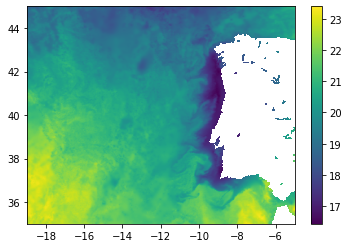

In [226]:
sst = sst.T
plt.pcolormesh(X, Y, sst, shading='flat')
plt.colorbar()
#este pcolormesh fica com os valores das coordenadas direitinhos

In [44]:
X.shape

(1001, 1401)

### Código: Definição da janela em Python 

In [227]:
head = np.array([-19, -5])           #Extremos do array que se obtem com a meshgrid em X
head = np.append(head, [35, 45])   #Extremos do array que se obtem com a meshgrid em Y

z_dim = Z.shape    #dimensões da matriz Z (rows, cols)

z_actual_range = np.array([np.nanmin(Z[:]), np.nanmax(Z[:])])    #range dos dados (valor minimo e maximo da matriz Z)
nx = z_dim[1]      # number of columns of matrix Z
ny = z_dim[0]      # number of rows of matrix Z
node_offset = 0
    
#index 4 -> menor valor de Z; index5 -> maior valor de Z; index6 -> node_offset=0
head = np.append(head, np.array([z_actual_range[0], z_actual_range[1] , node_offset]))    
head = np.append(head, np.array((head[1]- head[0])/(nx - int(not node_offset))))     #index 7 -> quociente da diferença dos extremos da meshgrid em X e o nr de colunas-1
head = np.append(head, np.array((head[3]- head[2])/(ny - int(not node_offset))))     #index 8 -> quociente da diferença dos extremos da meshgrid em Y e o nr de rows-1

In [228]:
head

array([-1.90000000e+01, -5.00000000e+00,  3.50000000e+01,  4.50000000e+01,
        1.64360008e+01,  2.33969994e+01,  0.00000000e+00,  1.00000000e-02,
        1.00000000e-02])

### Código: Definição da parametros Python

In [229]:
################################# 

# Window size 32 × 32

# Window clarity (% of data have to present in the window) 75%
# Overlap 50%

# The ratio of variance between the two populations to the
# variance within the populations θ(τopt )% 0.76

# Gradient ratio 0.9

# Cohesion coefficients [C1, C2, C] [0.9, 0.9, 0.92]
# Mean temperature difference between the two populations (surface waters)
# .25

#cayula
minPopProp = 0.20
minPopMeanDiff = 0.4
minTheta = 0.70
minSinglePopCohesion = 0.90
minGlobalPopCohesion = 0.70

#nieto
# minPopProp = 0.15
# minPopMeanDiff = 0.4
# minTheta = 0.70
# minSinglePopCohesion = 0.90
# minGlobalPopCohesion = 0.70

##################################

### Código: function getFrontInWindow() in Python

In [230]:
def getFrontInWindow(w, head, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, 
                     minGlobalPopCohesion, corners):
    
    #empty arrays de xdata, ydata e z
    xdata = np.array([])
    ydata = np.array([])
    z = np.array([])
    exitType=0
    
    #mask é um array com a shape de w, que vai ser 1 se nessa posição w for np.nan e 0 caso contrário
    mask = np.isnan(w).astype('int')  
    haveNaNs = np.any(mask[:]).astype('int')  #haveNaNs=1 se mask tiver 1s (que correspondem a NaNs na matriz w)
    n_NaNs=0
    
    if haveNaNs:
        n_NaNs = sum(mask.flatten()[:])       #contar nr de 1s (NaNs na matriz w) que existem
        if (n_NaNs/len(w.flatten())>0.5):     #window não pode ter mais de 50% dos seus pixeis como NaNs
            exitType=-1
            return 0,0,0,exitType
        
    mi_ma = [np.nanmin(w), np.nanmax(w)]        #array com valor minimo e máximo de w
    n = math.ceil((mi_ma[1]-mi_ma[0])/0.02)     #numero de bins
    bins = np.arange(mi_ma[0], mi_ma[1], 0.02)      #definir a sequencia dos Bins e ter resultados iguais ao MATLAB
    [y, xout] = np.histogram(w[:], bins, mi_ma)    #y->frequency counts, Xout->bin location
    xout = np.mean(np.vstack([xout[0:-1],xout[1:]]), axis=0)
    
    
    thresValue = xout[0]        
    totalCount = len(w.flatten()) - n_NaNs    #nr de pixeis não NaNs que existem
    threshPopACount = 0
    threshSeparation = -1
    threshPopAMean = 0
    threshPopBMean = 0
    
    w[mask==1] = 0    #Replace NaNs with 0's (quando o mask é 1 substituir valores do array w por 0)
    totalSum = sum(w.flatten())
    totalSumSquares = sum(w.flatten()*w.flatten())
    
    
    #Neste for loop ele vai descobrir qual é a linha que vai fazer a melhor separação entre a média da população  
    # da esquerda e da direita (A e B) - e esse vai ser o meu thresValue
    for k in range(1,n-1):     #ignore the first and last candidates (senão seria de 0 a n)
        popASum = sum(y[0:k+1] * xout[0:k+1])
        popBSum = sum(y[k+1:] * xout[k+1:])  
        popACount = sum(y[0:k+1])     #soma das frequências (y) do lado da população A
        popBCount = sum(y[k+1:])     #soma das frequências (y) do lado da população B
    
        popAMean = popASum/popACount
        try:           #este try aqui é uma estupidez (só para evitar o zerodivisionerror)
            popBMean = popBSum/popBCount
        except ZeroDivisionError:
            popBMean = 0
        separation = popACount * popBCount * (popAMean - popBMean) * (popAMean - popBMean)
        if separation>threshSeparation:
            threshSeparation = separation
            thresValue = xout[k]
            threshPopACount = popACount
            threshPopAMean = popAMean
            threshPopBMean = popBMean
            
            
        #abortar caso a proporção da população A seja menor que um dado minimo
    if (threshPopACount / totalCount < minPopProp):
        exitType = 1
        return 0,0,0,exitType  
    
    #abortar caso a proporção da população B seja menor que um dado minimo
    if (1.0 - threshPopACount / totalCount < minPopProp):
        exitType = 1
        return 0,0,0,exitType
    
    #abort this window if the difference in the populations means is less than a minimum value
    if (threshPopBMean - threshPopAMean < minPopMeanDiff):
        exitType = 2
        return 0,0,0,exitType
    
    #Calculate the criterion function THETA (TAUopt) in page 72 of the paper
    totalMean = totalSum/totalCount
    variance = totalSumSquares - (totalMean * totalMean * totalCount)
    theta = threshSeparation / (variance * totalCount)
    if (theta < minTheta):         #abortar caso theta seja menor que um dado minimo 
        exitType = 3
        return 0,0,0,exitType
    
    #Cohesion - agora que ja sei qual o valor de separação. Com base neste valor de separação vou elemento a
    #elemento da matriz, verificar se este é maior ou menor que a separação e conforme, 
    #vemos se é maior para baixo ou para a direita (quando é maior adiciono dum lado quando é menor adiciono do outro)
    #Count the nr of times a population A cell is immediately adjacent to another popA cell and the same for popB
    # A cell can be adjacent on 4 sides. Count only 2 of them (bottom and right side) because doing all 4 would be
    #redundant. Do not count diagonal neighbors
    countANextToA = 0
    countBNextToB = 0
    countANextToAOrB = 0
    countBNextToAOrB = 0
    [n_rows, n_cols] = w.shape
    for col in range(0, n_cols-1):
        for row in range(0, n_rows-1):
            if (haveNaNs & (mask[row, col] | mask[row+1, col] | mask[row, col+1])):
                continue
                         
            #examine the bottom neighbor
            if (w[row, col] <= thresValue):           # se o pixel da matriz for menor que o elemento de separação
                countANextToAOrB = countANextToAOrB + 1      #incrementar em 1 o countANextToAOrB
                if (w[row+1, col] <= thresValue):            #se pixel da linha de baixo for menor que separação
                    countANextToA = countANextToA + 1        #incrementar countANextToA
            else:                                            # se o pixel for maior que a separação
                countBNextToAOrB = countBNextToAOrB + 1      #incrementar countBNextToAOrB
                if (w[row+1, col] > thresValue):             #se o pixel da linha de baixo for maior que separação
                    countBNextToB = countBNextToB + 1        #incrementar countBNextToB
                         
                         
            # Examine the right neighbor
            if (w[row, col] <= thresValue):                     # se o pixel da matriz for menor que a separação      
                countANextToAOrB = countANextToAOrB + 1         # incrementar countANextToAOrB
                if (w[row, col+1] <= thresValue):               #se o pixel da direita for menor que separação
                    countANextToA = countANextToA + 1           # incrementar countANextToA
            else:                                               # se o pixel da matriz for maior que a separação
                countBNextToAOrB = countBNextToAOrB + 1         #incrementar countBNextToAOrB
                if (w[row, col+1] > thresValue):                #se o pixel da direita for maior que separação
                    countBNextToB = countBNextToB +1            # incrementar countBNextToB
                         
                         
    popACohesion = countANextToA / countANextToAOrB
    popBCohesion = countBNextToB/ countBNextToAOrB
    globalCohesion = (countANextToA + countBNextToB) / (countANextToAOrB + countBNextToAOrB)
    
    #Estes ifs são para caso surjam erros (parametros menores que certos limites)
    if (popACohesion < minSinglePopCohesion):
        exitType = 4
        return 0,0,0,exitType
                         
    if (popBCohesion < minSinglePopCohesion):
        exitType = 4
        return 0,0,0,exitType
                         
    if (globalCohesion < minGlobalPopCohesion):
        exitType = 4
        return 0,0,0,exitType
                         
                         
    #OK if we reach here we have a front. Compute its contour
    X = np.linspace(head[0], head[1], n_cols)    #Extremos do array que se obtem com a meshgrid em X##############
    Y = np.linspace(head[2], head[3], n_rows)
    if (corners.size == 0):
        w = w.astype('double')    
        if haveNaNs:
            w[w==0] = np.nan      # Need to restore the NaNs to not invent new contours around zeros
        
        c = plt.contour(X, Y, w, thresValue)
    else:
        #the 4 corners havethese indices [17,32,17,32; 17,32,1,16; 1,16,1,16;1,16,17,32]
        # and the variable corners has one of its rows (the current to be retained sub-window)
        #X = X[corners[0]-1:]
        #Y = Y[corners[0,0]-1]
       # w = w[corners[0,0]-1, corners[2,0]-1]
        
        X = X[np.arange(corners[2]-1, corners[3])]
        Y = Y[np.arange(corners[0]-1, corners[1])]
        w = w[np.arange(corners[0], corners[1]).min()-1:np.arange(corners[0], corners[1]).max()+1, np.arange(corners[2], corners[3]).min()-1:np.arange(corners[2], corners[3]).max()+1]
        
        if  haveNaNs:
            w[w==0] = np.nan     # Need to restore the NaNs to not invent new contours around zeros
                         
        if (np.isnan(w)).all()==True:
            c = np.array([])
        else:
            c = plt.contour(X, Y, w, thresValue)
                         
        limit = c.shape[1]
        i = 1
        while i<limit:
            npoints = c[1, i-1]
            x = c[0, i:i+npoints-1]
            y = c[1, i:i+npoints-1]
            
            if (x[0] == x[-1] or npoints<7):   #we dont want closed lines nor very short ones
                i = i+npoints+1
                continue
                         
            if (xdata.size == 0):
                xdata = x    #first contour
                ydata = y
            else:
                xdata = [xdata, np.nan, x]
                ydata = [ydata, np.nan, y]
                         
            i = i+npoints+1
            # xdata = c[0, 1:npoints+1]      ydata 0 c[1, 1:npoints+1]
        
        z = thresValue
        
        if (xdata.size == 0):
            exitType = 5;
            
    return xdata, ydata, z, exitType
            

### Código

/tmp/ipykernel_5285/2985117784.py:167: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, thresValue)


AttributeError: 'QuadContourSet' object has no attribute 'shape'

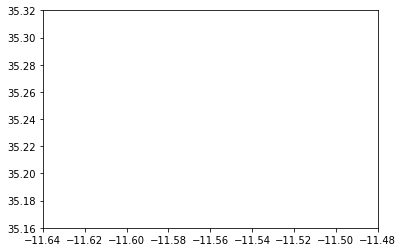

In [231]:
[n_rows, n_cols] = Z.shape
winW16 = 16
winW32 = 16*2
winW48 = 16*3

s=0 #s=1 means subwindows do NOT share a common border. With s = 0 they do.

xSide16 = winW16*head[7]
ySide16 = winW16*head[8]
xSide32 = (winW32 - s) * head[7]
ySide32 = (winW32 - s) * head[8]

nWinRows = math.floor(n_rows/winW16)
nWinCols = math.floor(n_cols/winW16)

#def draw_fig():
 #   plt.imshow(h)

for wRow in range(1, nWinRows-1):    #estava -3 antes
    r1 = (wRow-1) * winW16 + 1;
    r2 = r1 + winW48 -s     #start and stop indices and coords of current window
    y0 = head[2] + (wRow-1)*ySide16    #y1 = y0 + (winW48-1)*head[8]
    
    for wCol in range(1, nWinCols-1):     #estava -3 antes
        c1 = (wCol - 1)*winW16+1
        c2 = c1 + winW48 - s
        x0 = head[0] + (wCol-1) * xSide16     #x1 = x0 + (winW48-1)*head[7]
        wPad = Z[r1-1:r2, c1-1:c2]
        
        rr = np.array([1,1,2,2])
        cc = np.array([1,2,2,1])
        
        if s==1:
            corners = np.array([[17, 32, 17, 32], [17, 32, 1, 16], [1, 16, 1, 16], [1, 16, 17, 32]])  #less good
        else:
            corners = np.array([[17, 33, 17, 33], [17, 33, 1, 17], [1, 17, 1, 17], [1, 17, 17, 33]])
            
        for k in range(0,4):     #loop over the 4 slidding 32X32 sub-windows of the larger 48x48 one
            m1 = (rr[k] - 1) * winW16 + 1
            m2 = m1 + 2 * winW16 - s             #indices of the slidding 33X33 window
            n1 = (cc[k] - 1) * winW16 + 1
            n2 = n1 + 2 * winW16 - s
            
            w = wPad[m1-1:m2, n1-1:n2].astype('double')      #sub window with size 33x33
            
            subWinX0 = x0 + (cc[k] - 1) * xSide16
            subWinX1 = subWinX0 + xSide32
            
            subWinY0 = y0 + (rr[k] - 1) * ySide16
            subWinY1 = subWinY0 + ySide32
            
            R = np.array([subWinX0, subWinX1, subWinY0, subWinY1])
          
            xdata, ydata, z, exitType = getFrontInWindow(w, R, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, minGlobalPopCohesion, corners[k,:])
            
            if (exitType == 0):
                #  h = line('XData', x, 'YData', y, 'userdata', z, 'Tag', 'SSTfront')  
                #Tag -> nas propriedades da imagem, a figure vai ter o Tag 'SSTfront' (em MATLAB)
                h = plt.plot(xdata,ydata,z)       #DUVIDA
    
    #drawnow(draw_fig)
                
                
        #DUVIDA se uso o drawnow?
    plt.show()
        
        

In [204]:
corners

array([[17, 33, 17, 33],
       [17, 33,  1, 17],
       [ 1, 17,  1, 17],
       [ 1, 17, 17, 33]])

In [206]:
corners = corners[3,:]

In [207]:
corners

array([ 1, 17, 17, 33])